In [35]:
import json
import os
import numpy as np

In [36]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [37]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/speech-reco-data/data.json'

## Data split

Connect to google drive for data

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
with open(DATA_PATH) as f:
    data = json.load(f)

In [40]:
X = np.array(data['MFCCs'])
y = np.array(data['labels'])

In [41]:
from sklearn.model_selection import train_test_split

test_size = 0.1
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)

In [42]:
# convert from 2D to 3D
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Finding best model

In [43]:
import tensorflow.keras as keras

l2_reg = 0.001
n_classes = len(np.unique(y_train))
input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]) # segments, coefficients(13), 1

models = []
results = []

### Models building

In [44]:
model = keras.Sequential(name='baseline')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [45]:
model = keras.Sequential(name='reversedconvincrase')

# block 1
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [46]:
model = keras.Sequential(name='b1multiply')

# block 1
model.add(keras.layers.Conv2D(128, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [47]:
model = keras.Sequential(name='b2multiply2')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [48]:
model = keras.Sequential(name='b3multiply')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [49]:
model = keras.Sequential(name='b1andb2multiplyb3multiply')

# block 1
model.add(keras.layers.Conv2D(128, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)

In [50]:
model = keras.Sequential(name='paddinginevery')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                              input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)
# padding same in every block

In [51]:
model = keras.Sequential(name='plusblock4')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

#block 4
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)
# + block 4

In [52]:
model = keras.Sequential(name='biggerdense')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)
# dense layer 64 -> 128

In [53]:
model = keras.Sequential(name='biggerdenseanddropout')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.5))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)
# dense layer 64 -> 128 + dropout -> 0.5

In [54]:
model = keras.Sequential(name='lr')

# block 1
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', 
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

models.append(model)
# lr * 10

### Models evaluation

In [55]:
batch_size = 64
epochs = 50

In [56]:
for model in models:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
         validation_data=(X_val, y_val))
  
  test_error, test_accuracy = model.evaluate(X_test, y_test)
  results.append([model.name, history, [test_error, test_accuracy]])

Epoch 1/50
738/738 [==============================] - 5s 5ms/step - loss: 3.2952 - accuracy: 0.1187 - val_loss: 2.6824 - val_accuracy: 0.2968
Epoch 2/50
738/738 [==============================] - 4s 5ms/step - loss: 2.4368 - accuracy: 0.3210 - val_loss: 1.8628 - val_accuracy: 0.5323
Epoch 3/50
738/738 [==============================] - 4s 5ms/step - loss: 1.8513 - accuracy: 0.4802 - val_loss: 1.3793 - val_accuracy: 0.6548
Epoch 4/50
738/738 [==============================] - 3s 5ms/step - loss: 1.4972 - accuracy: 0.5792 - val_loss: 1.0934 - val_accuracy: 0.7305
Epoch 5/50
738/738 [==============================] - 4s 5ms/step - loss: 1.2667 - accuracy: 0.6436 - val_loss: 0.9336 - val_accuracy: 0.7679
Epoch 6/50
738/738 [==============================] - 4s 5ms/step - loss: 1.1131 - accuracy: 0.6874 - val_loss: 0.8398 - val_accuracy: 0.7822
Epoch 7/50
738/738 [==============================] - 4s 5ms/step - loss: 1.0014 - accuracy: 0.7216 - val_loss: 0.7591 - val_accuracy: 0.8081
Epoch 

### Plot training

In [57]:
import matplotlib.pyplot as plt

def plot_metrics(title, history, figsize=(10, 8)):
  # figure, axes = plt.subplots(2, 1, figsize=(10, 8))
  plt.figure(figsize=figsize)
  # plot accuracy
  plt.subplot(2, 1, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title + ' model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.figure(figsize=figsize)
  plt.subplot(2, 1, 2)
  # plot loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title + ' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [58]:
len(results)

11

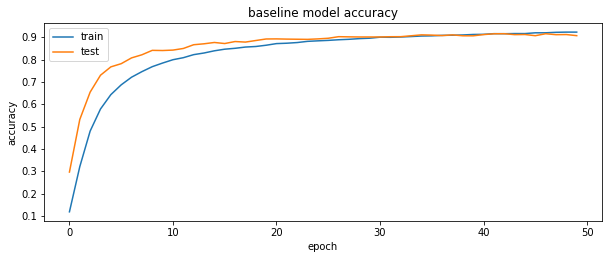

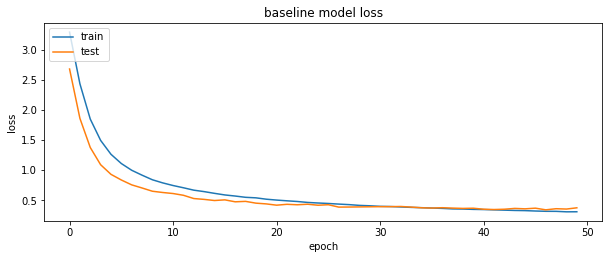

In [59]:
n = 0
plot_metrics(results[n][0], results[n][1])

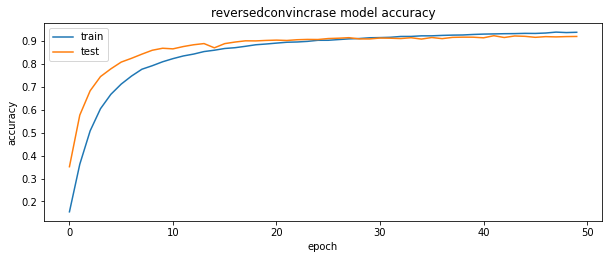

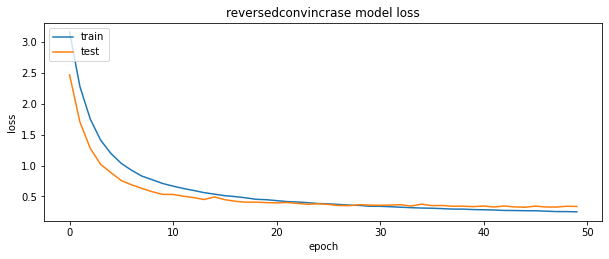

In [60]:
n = 1
plot_metrics(results[n][0], results[n][1])

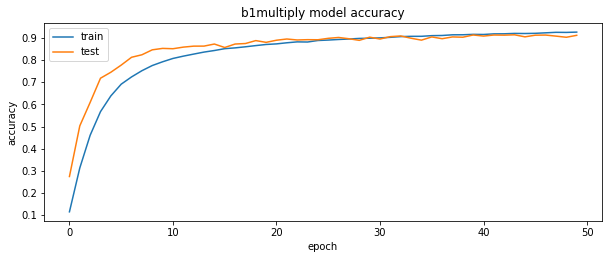

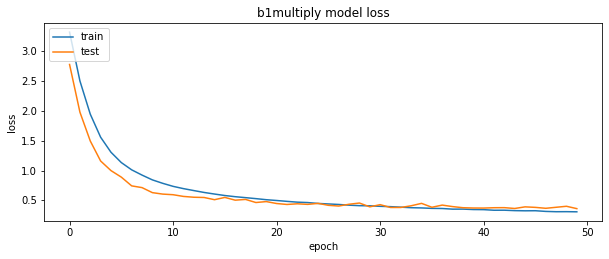

In [61]:
n = 2
plot_metrics(results[n][0], results[n][1])

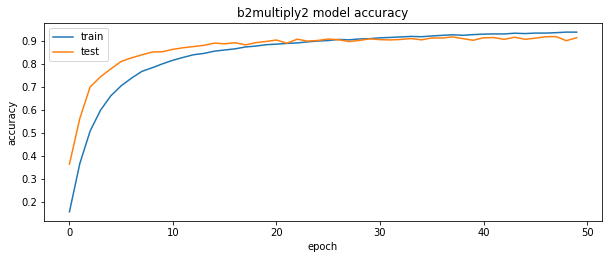

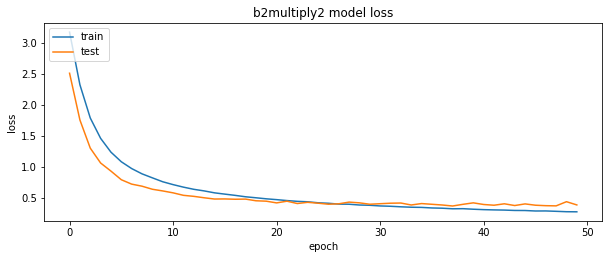

In [62]:
n = 3
plot_metrics(results[n][0], results[n][1])

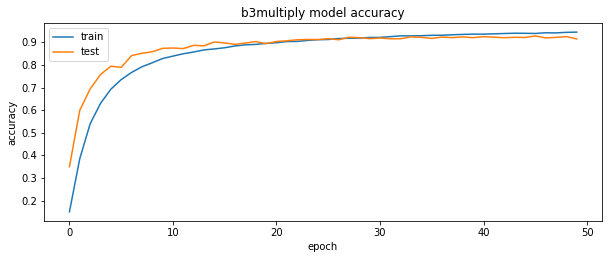

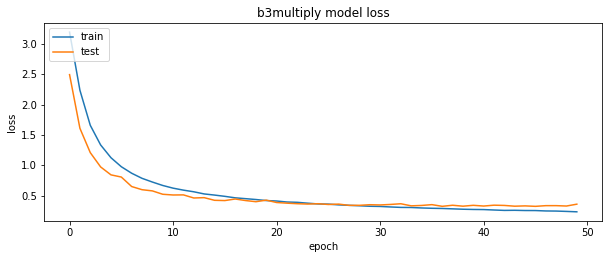

In [63]:
n = 4
plot_metrics(results[n][0], results[n][1])

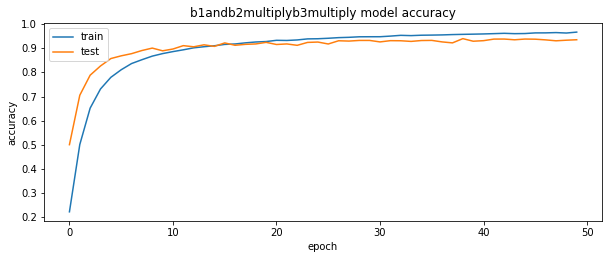

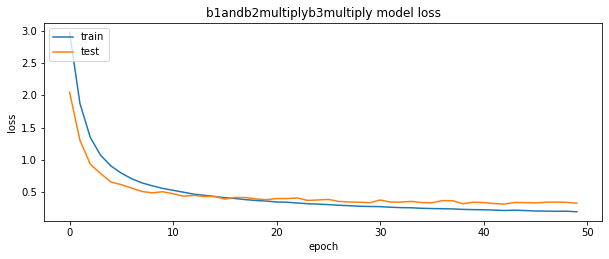

In [64]:
n = 5
plot_metrics(results[n][0], results[n][1])

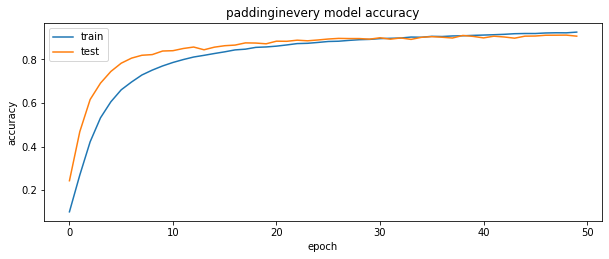

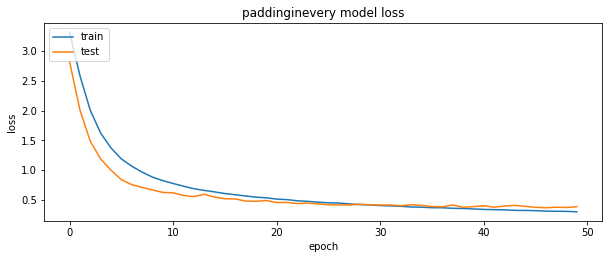

In [65]:
n = 6
plot_metrics(results[n][0], results[n][1])

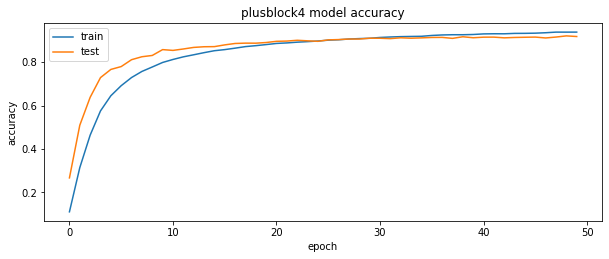

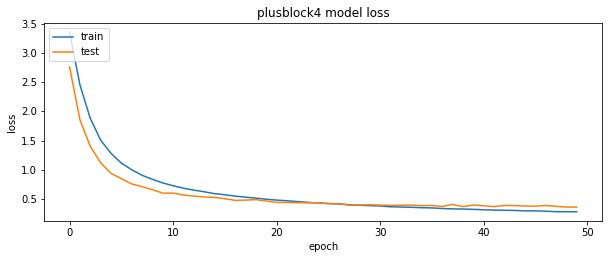

In [66]:
n = 7
plot_metrics(results[n][0], results[n][1])

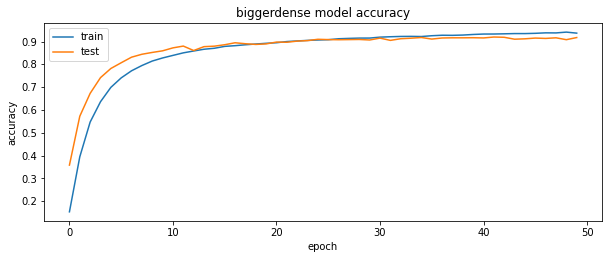

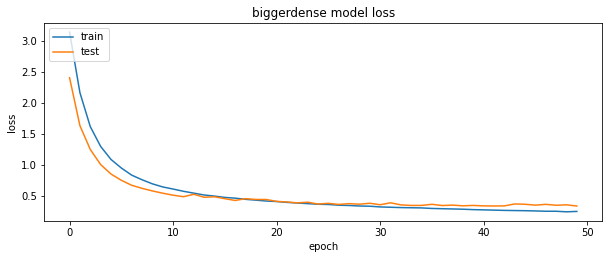

In [67]:
n = 8
plot_metrics(results[n][0], results[n][1])

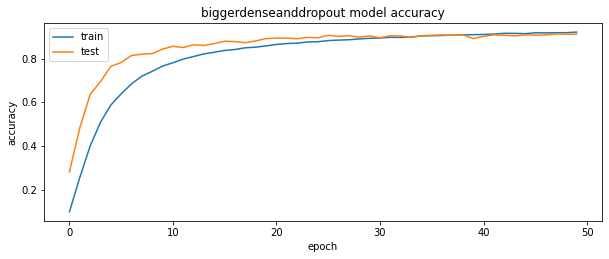

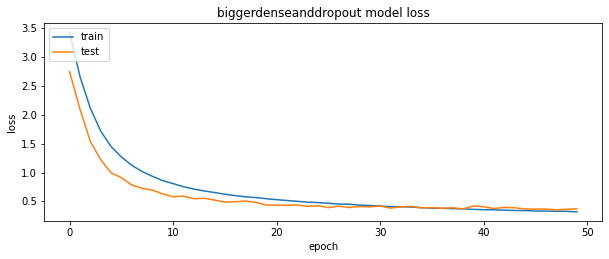

In [68]:
n = 9
plot_metrics(results[n][0], results[n][1])

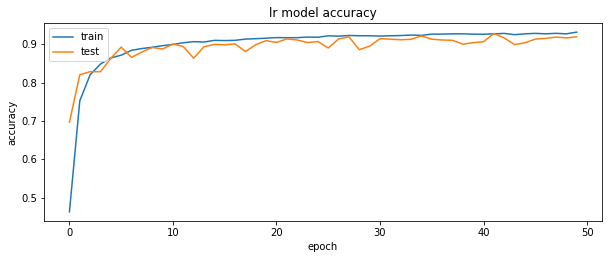

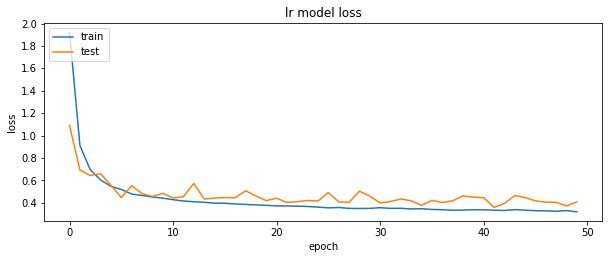

In [70]:
n = 10
plot_metrics(results[n][0], results[n][1])

In [71]:
for r in results:
  print(f"Last training accuracy: {r[1].history['accuracy'][-1]}, Test accuracy: {r[2][1]}   {r[0]}")

Last training accuracy: 0.9235741496086121, Test accuracy: 0.8956402540206909   baseline
Last training accuracy: 0.9389186501502991, Test accuracy: 0.9164091944694519   reversedconvincrase
Last training accuracy: 0.9261598587036133, Test accuracy: 0.9059389233589172   b1multiply
Last training accuracy: 0.9389610886573792, Test accuracy: 0.9129763245582581   b2multiply2
Last training accuracy: 0.9447470307350159, Test accuracy: 0.907483696937561   b3multiply
Last training accuracy: 0.9665345549583435, Test accuracy: 0.9322004914283752   b1andb2multiplyb3multiply
Last training accuracy: 0.9254816174507141, Test accuracy: 0.9028493165969849   paddinginevery
Last training accuracy: 0.9376470446586609, Test accuracy: 0.9145210981369019   plusblock4
Last training accuracy: 0.9369476437568665, Test accuracy: 0.9193271398544312   biggerdense
Last training accuracy: 0.9204586148262024, Test accuracy: 0.9078269600868225   biggerdenseanddropout
Last training accuracy: 0.9312888383865356, Test acc

## Final model

In [86]:
model = keras.Sequential(name='baseline')

# block 1
model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                              input_shape = input_shape, 
                              kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

# block 2
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3, 3), strides=(2,2), padding='same'))

#block 3
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

#block 4
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                             kernel_regularizer = keras.regularizers.l2(l2_reg)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(rate = 0.5))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

lr = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [87]:
history = model.fit(X_train, y_train, 
                    epochs=100,#epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val))
  
test_error, test_accuracy = model.evaluate(X_test, y_test)



Epoch 1/100
738/738 [==============================] - 6s 8ms/step - loss: 3.2447 - accuracy: 0.1593 - val_loss: 2.4123 - val_accuracy: 0.4223
Epoch 2/100
738/738 [==============================] - 6s 8ms/step - loss: 2.2018 - accuracy: 0.4034 - val_loss: 1.4674 - val_accuracy: 0.6656
Epoch 3/100
738/738 [==============================] - 6s 8ms/step - loss: 1.5930 - accuracy: 0.5744 - val_loss: 1.0797 - val_accuracy: 0.7482
Epoch 4/100
738/738 [==============================] - 5s 7ms/step - loss: 1.2584 - accuracy: 0.6748 - val_loss: 0.8721 - val_accuracy: 0.8051
Epoch 5/100
738/738 [==============================] - 5s 7ms/step - loss: 1.0645 - accuracy: 0.7323 - val_loss: 0.8163 - val_accuracy: 0.8159
Epoch 6/100
738/738 [==============================] - 5s 7ms/step - loss: 0.9298 - accuracy: 0.7754 - val_loss: 0.7069 - val_accuracy: 0.8451
Epoch 7/100
738/738 [==============================] - 5s 7ms/step - loss: 0.8329 - accuracy: 0.8043 - val_loss: 0.6484 - val_accuracy: 0.8608

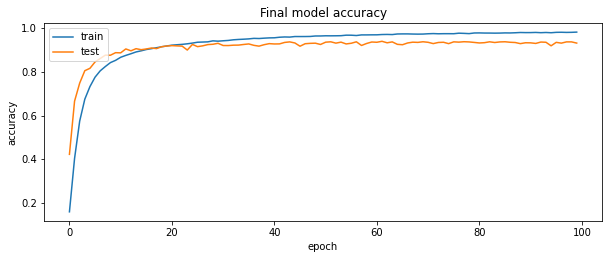

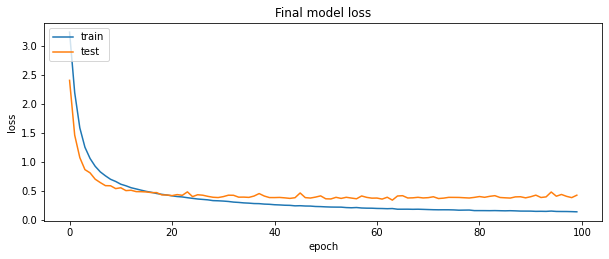

In [89]:
plot_metrics('Final', history)

In [90]:
print(f"Last training accuracy: {history.history['accuracy'][-1]}, Test accuracy: {test_accuracy}")

Last training accuracy: 0.9816035628318787, Test accuracy: 0.9291108846664429


## Save model

In [32]:
model_path = 'model.h5'
model.save(model_path)

In [33]:
! conda install -c anaconda flask  -y

/bin/bash: conda: command not found


In [34]:
! conda install -c conda-forge uwsgi -y

/bin/bash: conda: command not found
